# Simulating single channels with Myokit

This was previously part of the analytical solvers for simple step protocols module in the tutorial for myokit an dpints done by Michael Clerx: more protocols number 3

## Analytical solutions for Markov models

If our ion current model is written as a Markov model using the module [myokit.lib.markov](https://myokit.readthedocs.io/api_library/markov.html).

This time, we create a [myokit.lib.markov.LinearModel](https://myokit.readthedocs.io/api_library/markov.html#myokit.lib.markov.LinearModel), and use a [myokit.lib.markov.AnalyticalSimulation](https://myokit.readthedocs.io/api_library/markov.html#myokit.lib.markov.AnalyticalSimulation):

0.026526510999246966
0.08901729699937277


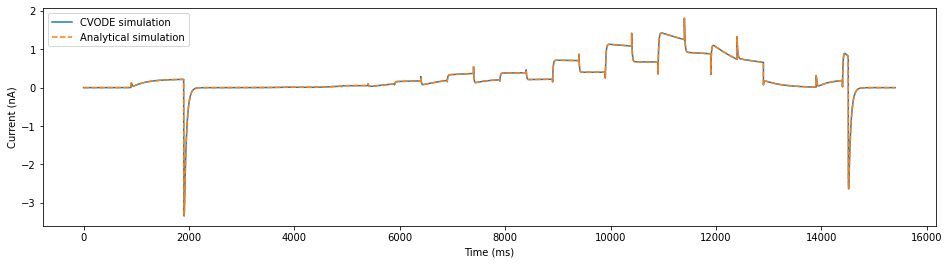

In [36]:
import matplotlib.pyplot as plt
import numpy as np

import myokit
import myokit.lib.markov

# Load a model: this is the same model as before, but coded up as a Markov model (a kinetic scheme)
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')

# Load a protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
markov_model = myokit.lib.markov.LinearModel.from_component(model.get('ikr'), parameters=parameters)

# Create an analytical simulation
markov_sim = myokit.lib.markov.AnalyticalSimulation(markov_model, protocol)

# Create a CVODE simulation
cvode_sim = myokit.Simulation(model, protocol)

# Select times to log
tmax = 15400
times = np.arange(0, tmax, 0.1)

# Run a timed simulation with each method:
b = myokit.Benchmarker()
hh_log = markov_sim.run(tmax, log_times=times)
print(b.time())

b.reset()
cvode_log = cvode_sim.run(tmax, log_times=times, log=['ikr.IKr'])
print(b.time())

plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, hh_log['ikr.IKr'], '-', label='CVODE simulation')
plt.plot(times, cvode_log['ikr.IKr'], '--', label='Analytical simulation')
plt.legend(loc='upper left')
plt.show()

## Single channel simulations

Markov models can also be used for discrete, single channel, simulations. Each channel can be in 4 different states: Open (y3), Closed (y4), Inactive (y2), InactiveClosed (y1)


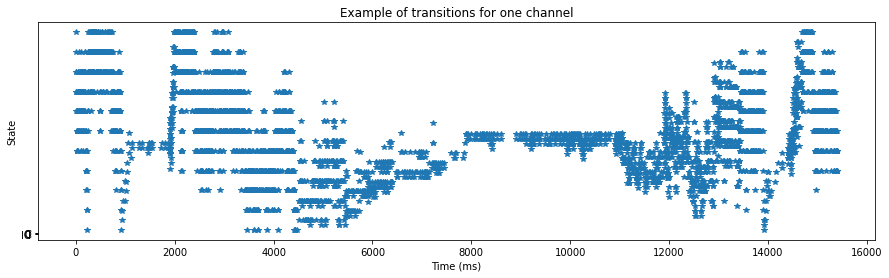

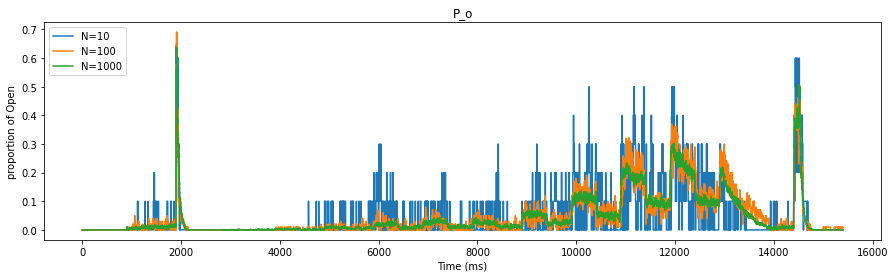

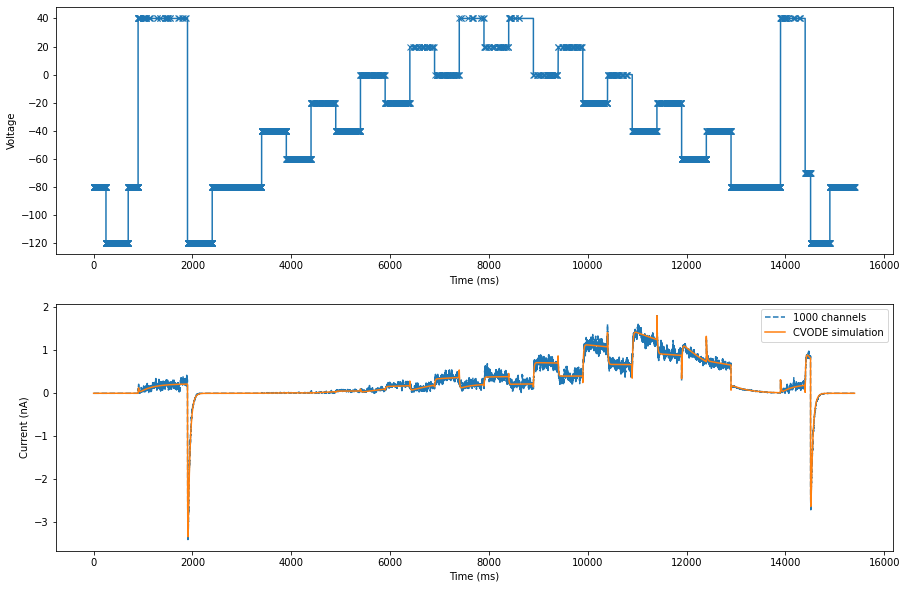

In [37]:

tlog = tmax
# Simulate the first three seconds of the protocol, with various numbers of channels
N1 = 10
sim_N1 = myokit.lib.markov.DiscreteSimulation(markov_model, protocol, nchannels=N1)
log_N1 = sim_N1.run(tlog)
# N = 1
N2 = 100
sim_N2 = myokit.lib.markov.DiscreteSimulation(markov_model, protocol, nchannels=N2)
log_N2 = sim_N2.run(tlog)
# N= 10
N3=1000
sim_N3 = myokit.lib.markov.DiscreteSimulation(markov_model, protocol, nchannels = N3)
log_N3 = sim_N3.run(tlog)

# To mark the time (?) 
b = myokit.Benchmarker()


# Example of one channel changing states state of the channel
# Create a figure
plt.figure(figsize=(15,4))
plt.title('Example of transitions for one channel')
plt.plot(log_N1.time(),np.array(log_N1['ikr.y1'])+np.array(log_N1['ikr.y2'])*2*N1 + np.array(log_N1['ikr.y3'])*N1+ np.array(log_N1['ikr.y4'])*4*N1 , '*', drawstyle='steps-post')
plt.yticks([1,2,3,4],['IC','I','O','C'])
plt.xlabel('Time (ms)')
plt.ylabel('State')

# plot the open proabability
plt.figure(figsize=(15,4))
plt.title('P_o')
plt.plot(log_N1.time(),np.array(log_N1['ikr.y3'])/N1, drawstyle='steps-post', label='N=' + str(N1))
plt.plot(log_N2.time(),np.array(log_N2['ikr.y3'])/N2, drawstyle='steps-post', label='N=' + str(N2))
plt.plot(log_N3.time(),np.array(log_N3['ikr.y3'])/N3, drawstyle='steps-post', label='N=' + str(N3))
plt.xlabel('Time (ms)')
plt.ylabel('proportion of Open')
plt.legend()

# Next figure
# Create a figure
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.plot(log_N1.time(), log_N1['membrane.V'], 'x-', drawstyle='steps-post')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')

# Mean current
plt.subplot(2, 1, 2)
#plt.plot(log_N1.time(), log_N1['ikr.IKr'],'--', drawstyle='steps-post', label=str(N1)+' channels')
#plt.plot(log_N2.time(), log_N2['ikr.IKr'],'--', drawstyle='steps-post', label=str(N2)+' channels')
plt.plot(log_N3.time(), log_N3['ikr.IKr'],'--', drawstyle='steps-post', label=str(N3)+' channels')
plt.plot(times, hh_log['ikr.IKr'], '-', label='CVODE simulation')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.legend()





plt.show()

## A different protocol to get simpler simulations 

I'm gonna pick one the protocols (stair case stile) to simulate simpler currents. I'm trying to look into how the variance changes wrt:

1. Number of channels N
2. Open probability -> what is the definition of it?
3. How do I stranslate the binomial distribution to here? Since I only care about O, then $p_O = $?? From the Markov model, I know how to calculate/relate $p(O(t)=x|O(t-\Delta t)=x\pm 1)$, but I'm not sure how that relates to the negative binomial distribution, and hence how to interprete $p_O$
4. Would the values of N affet the value of $p_O$ with the current simulations?

Start with $\sigma^2 = I*i0-I^2/N$ for $N=10,100,1000$, one full simulation

odict_keys(['engine.time', 'membrane.V', 'ikr.y1', 'ikr.y2', 'ikr.y3', 'ikr.y4', 'ikr.IKr'])


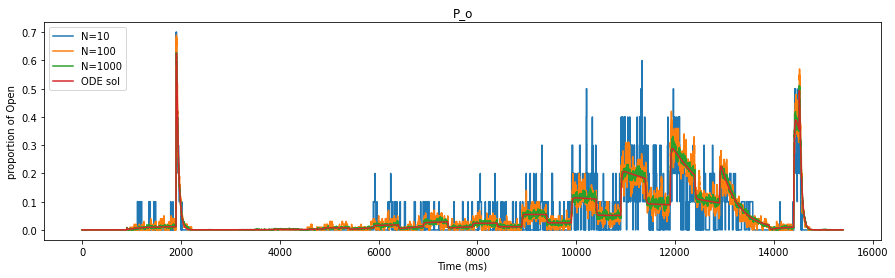

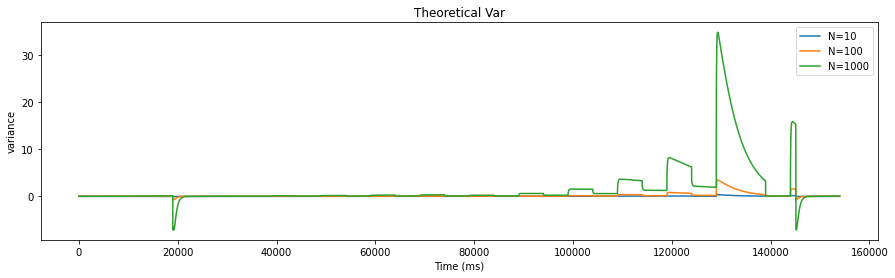

In [22]:

# plot the open proabability mean vs proportions
plt.figure(figsize=(15,4))
plt.title('P_o')
plt.plot(log_N1.time(),np.array(log_N1['ikr.y3'])/N1, drawstyle='steps-post', label='N=' + str(N1))
plt.plot(log_N2.time(),np.array(log_N2['ikr.y3'])/N2, drawstyle='steps-post', label='N=' + str(N2))
plt.plot(log_N3.time(),np.array(log_N3['ikr.y3'])/N3, drawstyle='steps-post', label='N=' + str(N3))
plt.plot(hh_log.time(),hh_log['ikr.y3'], drawstyle='steps-post', label='ODE sol')
plt.xlabel('Time (ms)')
plt.ylabel('proportion of Open')
plt.legend()


# Let's call p_0 = ode sol, V = membrane potencial, Ek
p0 = np.array(hh_log['ikr.y3'])
#p0_time = np.array(hh_log.time)
V = np.array(hh_log['membrane.V'])
Ek = -85
# for simplification let's store p(1-p)
varterm = p0*(1-p0)/(V-Ek)

# Let's plot the variance for the different N's
plt.figure(figsize=(15,4))
plt.title('Theoretical Var')
plt.plot(varterm*N1, drawstyle='steps-post', label='N=' + str(N1))
plt.plot(varterm*N2, drawstyle='steps-post', label='N=' + str(N2))
plt.plot(varterm*N3, drawstyle='steps-post', label='N=' + str(N3))
plt.xlabel('Time (ms)')
plt.ylabel('variance')
plt.legend()


plt.show()
print(log_N1.keys())

(3964,)
(40123,)


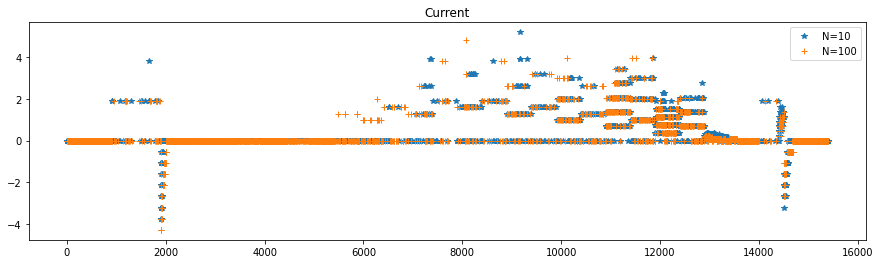

In [43]:
# Define the currents I:
I1 = np.array(log_N1['ikr.IKr'])
time1 = np.array(log_N1['engine.time'])
I2 = np.array(log_N2['ikr.IKr'])
I3 = np.array(log_N3['ikr.IKr'])
print(np.shape(I1))
print(np.shape(I2))


# Modify by changing a simulation object
b.reset()
sim_N1.reset() 
sim_N2.reset()
sim_N3.reset()

# simulate many times
log_N1 = sim_N1.run(tlog)

plt.figure(figsize=(15,4))
plt.title('Current')
plt.plot(log_N1['engine.time'],np.array(log_N1['ikr.IKr']),'*', drawstyle='steps-post', label='N=' + str(N1))
plt.plot(time1, I1,'+', drawstyle='steps-post', label='N=' + str(N2))
plt.legend()



plt.show()


